# Gibbs sampling

Originally by Weichao Qiu, modified for Fall 2016 by Drew Reisinger

If you find this ipython notebook is unclear or contains bugs, please contact Drew at reisinger@cogsci.jhu.edu  
If there's an error says "something is undefined", please run the cell that contains the definition or use "menu -> cell -> run all above"

The data and code can be downloaded here: [tgz](https://github.com/drew-reisinger/AS.50.375HWFall16/blob/master/HW3.tgz) or [zip](https://github.com/drew-reisinger/AS.50.375HWFall16/blob/master/HW3.zip)

# Foreground/background classification.

Here we consider a model for foreground/background classification that can include spatial context. Intuitively, neighboring pixels in the image are likely to belong to the same class, i.e. are likely to be either all background or all foreground. This is a form of prior knowledge, or natural statistic, which can be learnt by analyzing natural images.

For pixel $i$, the foreground label is $ S_i = 1 $, and background label is $ S_i = -1 $.

The prior term in the energy encourages neighbouring pixels to have the same intensity ($N(i)$ is the set of pixels neighboring $i$):  
$ E_p[S] = \gamma \sum_{i} \sum_{j \in N(i)} { - S_i S_j} $ 

The data term is defined as:

$ E_d[S, I] = \eta \sum_{i} (I_i - S_i)^2 $


These two terms are combined to get the energy.

$ E[S] = E_p[S] + E_d[S, I] $

Then the posterior of the labeling $S$ given the image $I$ (with temperature parameter $T$) is

$ P(S|I) = \frac{1}{Z} \exp\left( - \frac{E[S]}{T} \right) $

The block of code below initializes the ipython notebook

In [1]:
# Initiialization code
%matplotlib inline
import numpy as np
# from pylab import imshow, show, get_cmap, imread, figure, subplots, title, subplot
import matplotlib.pyplot as plt
from numpy import random

The block of code below loads an image and normalizes it to the  range $[-1, 1]$.

original range: 0.0 0.846330682811
remapped range: -1.0 1.0


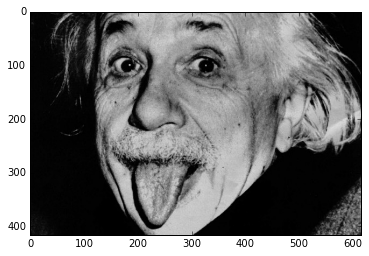

In [2]:
im = plt.imread('data/gibbs/gibbs_demo.jpg')
plt.imshow(im)

def myimshow(state):
    plt.imshow(state, interpolation='nearest')

# Preprocess image to range (-1, 1)
def preproc_data(im, scale=0.1, debug=False):
    import skimage.color
    import skimage.transform
    
    tinyim = skimage.transform.rescale(im, scale)
    grayim = skimage.color.rgb2gray(tinyim)

    # Linear map the data to -1, 1
    scale = grayim.max() - grayim.min()
    data = 2 * (grayim - grayim.min()) / scale - 1
    if debug:
        print 'original range:', grayim.min(), grayim.max()
        print 'remapped range:', data.min(), data.max()

    return [data, tinyim]

[data, im] = preproc_data(im, debug=True) # data is normalized image

The block of code below defines the neighborhood structure for the Gibbs sampler.

In [3]:
def getneighor(y, x, h, w): # get 4-side neighbor
    n = []
    if (x != 0): n.append((y, x-1))
    if (x != w-1): n.append((y, x+1))
    if (y != 0): n.append((y-1, x))
    if (y != h-1): n.append((y+1, x))
    return n

def poslist(h,w):
    '''Get point list of a grid'''
    pos = []
    for x in range(w):
        for y in range(h):
            pos.append((y, x))
    return pos

Define a utility function to compute energy.

In [43]:
def energy_prior(state, gamma):
    total = 0
    (h, w) = state.shape
    pos = poslist(h, w)
    for p in pos:
        neighbor = getneighor(p[0], p[1], h, w) # compute neighbor
        
        for n in neighbor:
            total += state[p[0]][p[1]] * state[n[0]][n[1]]
    E = - gamma * total
    return E
        
def energy_data(state, data, eta):
    E = eta * sum(sum((data - state)**2)) #fixed an error
    return E

def energy(state, data, gamma, eta):
    return energy_prior(state, gamma) + energy_data(state, data, eta)

Define the Gibbs sampler.

In [5]:
def gibbs_sampler(state, data, gamma, eta, debug=False): # 0/1 state
    (h, w) = state.shape
    new_state = state.copy()
    pos = poslist(h, w)
    for p in pos:
        neighbor_pos = getneighor(p[0], p[1], h, w)
        neighbor_value = [new_state[n[0]][n[1]] for n in neighbor_pos]

        tmp1 = -gamma * -1 * sum(neighbor_value) # x_i = -1
        tmp2 = -gamma * 1 * sum(neighbor_value) # x_i = 1
        
        # add data term
        v = data[p[0]][p[1]]
        tmp1 += eta * (v - (-1))**2 # x_i = -1
        tmp2 += eta * (v - 1)**2 #  x_i = 1
        
        tmp1 = np.exp(-tmp1)
        tmp2 = np.exp(-tmp2)

        p1 = tmp1 / (tmp1 + tmp2)
        prob = random.uniform() # roll a dice
        
        if (debug): print p1
        if (prob > p1):
            new_state[p[0]][p[1]] = 1
        else:
            new_state[p[0]][p[1]] = -1
    return new_state

# Animation: sample with data term included
Run this demo below; make sure to watch the animation as it happens!

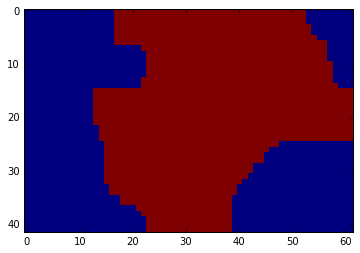

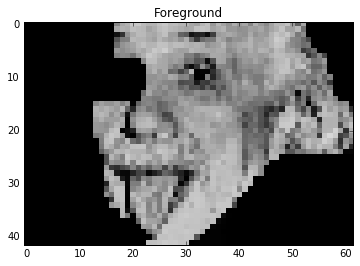

In [24]:
from IPython.display import display, clear_output
import time

random_seed = 50 # Change this in your experiment
random.seed(random_seed)

(h, w) = data.shape
mat = random.random((h,w))
mat[mat>0.5] = 1
mat[mat<=0.5] = -1
random_state = mat

# Initial the random state
init_state = random_state

# Set parameters
gamma = 20
eta = 1

new_state = random_state.copy()
E = [energy(init_state, data, gamma, eta)] # array of energies at each iteration
print E
f, ax = plt.subplots() # prepare animation
for i in range(60):
    clear_output(wait=True)
    new_state = gibbs_sampler(new_state, data, gamma, eta)
    E.append(energy(new_state, data, gamma, eta))

    # time.sleep(1)
    myimshow(new_state)
    display(f)

plt.title("Foreground")
mask = (new_state==1)
fg = im.copy()
for i in range(3): 
    fg[:,:,i] = fg[:,:,i] * mask
plt.imshow(fg, cmap='gray', interpolation='nearest')


# HW2.2 Gibbs sampler
Set random_seed to a different value (and tell me what it is in your homework!)
1. Try a few different values of $ \gamma $, $ \eta $, including special case that only contains the prior term. What happens when the parameters change?
2. Run with different images, plot your results. Find two or three images from the web or your image collection. Can you find an image that causes the model to identify the foreground poorly?
3. Around what iteration does the sampler converge for the Einstein image with $ \gamma = 20 $ and $ \eta = 1 $ and how do you know it? Don't just say "the image stopped changing very much"! Hint: look carefully at the demo above to see if there's anything that will help you diagnose convergence.

### Answer 1.

Try a few different values of γ, η, including special case that only contains the prior term. What happens when the parameters change?

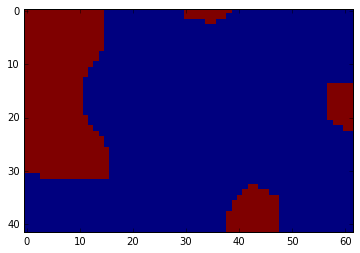

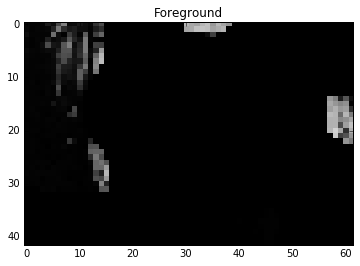

In [7]:
##what about eta = 0?

from IPython.display import display, clear_output
import time

random_seed = 100 # Change this in your experiment
random.seed(random_seed)

(h, w) = data.shape
mat = random.random((h,w))
mat[mat>0.5] = 1
mat[mat<=0.5] = -1
random_state = mat

# Initial the random state
init_state = random_state

# Set parameters
gamma = 20
eta = 0

new_state = random_state.copy()
E = [energy(init_state, data, gamma, eta)] # array of energies at each iteration

f, ax = plt.subplots() # prepare animation
for i in range(60):
    clear_output(wait=True)
    new_state = gibbs_sampler(new_state, data, gamma, eta)
    E.append(energy(new_state, data, gamma, eta))

    # time.sleep(1)
    myimshow(new_state)
    display(f)

plt.title("Foreground")
mask = (new_state==1)
fg = im.copy()
for i in range(3): 
    fg[:,:,i] = fg[:,:,i] * mask
plt.imshow(fg, cmap='gray', interpolation='nearest')

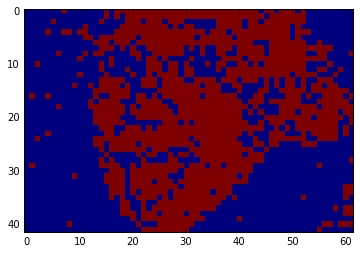

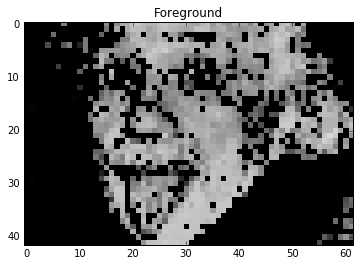

In [8]:
##What about gamma = 0?

from IPython.display import display, clear_output
import time

random_seed = 200 # Change this in your experiment
random.seed(random_seed)

(h, w) = data.shape
mat = random.random((h,w))
mat[mat>0.5] = 1
mat[mat<=0.5] = -1
random_state = mat

# Initial the random state
init_state = random_state

# Set parameters
gamma = 0
eta = 1

new_state = random_state.copy()
E = [energy(init_state, data, gamma, eta)] # array of energies at each iteration

f, ax = plt.subplots() # prepare animation
for i in range(60):
    clear_output(wait=True)
    new_state = gibbs_sampler(new_state, data, gamma, eta)
    E.append(energy(new_state, data, gamma, eta))

    # time.sleep(1)
    myimshow(new_state)
    display(f)

plt.title("Foreground")
mask = (new_state==1)
fg = im.copy()
for i in range(3): 
    fg[:,:,i] = fg[:,:,i] * mask
plt.imshow(fg, cmap='gray', interpolation='nearest')

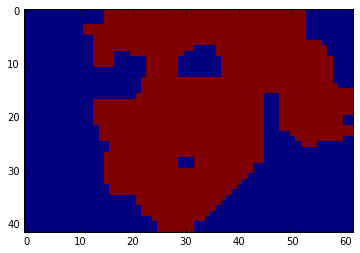

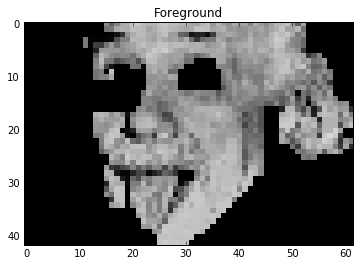

In [11]:
##let's give more weight on eta, keep gamma lower
from IPython.display import display, clear_output
import time

random_seed = 300 # Change this in your experiment
random.seed(random_seed)

(h, w) = data.shape
mat = random.random((h,w))
mat[mat>0.5] = 1
mat[mat<=0.5] = -1
random_state = mat

# Initial the random state
init_state = random_state

# Set parameters
gamma = 20
eta = 10

new_state = random_state.copy()
E = [energy(init_state, data, gamma, eta)] # array of energies at each iteration

f, ax = plt.subplots() # prepare animation
for i in range(60):
    clear_output(wait=True)
    new_state = gibbs_sampler(new_state, data, gamma, eta)
    E.append(energy(new_state, data, gamma, eta))

    # time.sleep(1)
    myimshow(new_state)
    display(f)

plt.title("Foreground")
mask = (new_state==1)
fg = im.copy()
for i in range(3): 
    fg[:,:,i] = fg[:,:,i] * mask
plt.imshow(fg, cmap='gray', interpolation='nearest')

### Answer 2
Run with different images, plot your results. Find two or three images from the web or your image collection. Can you find an image that causes the model to identify the foreground poorly?

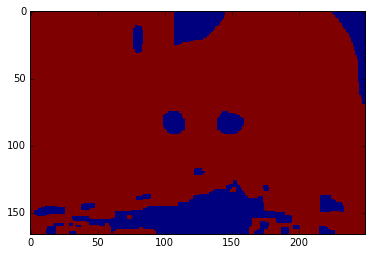

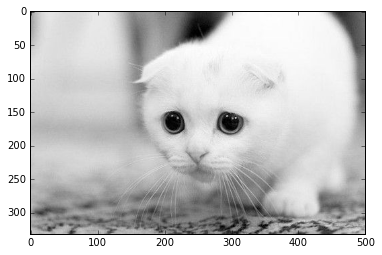

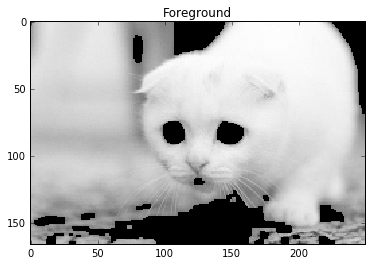

In [32]:
im = plt.imread('data/gibbs/try1.jpeg')
plt.imshow(im)
[data, im] = preproc_data(im, scale =0.5, debug=True) # data is normalized image
##let's give more weight on eta, keep gamma lower

random_seed = 300 # Change this in your experiment
random.seed(random_seed)

(h, w) = data.shape
mat = random.random((h,w))
mat[mat>0.5] = 1
mat[mat<=0.5] = -1
random_state = mat

# Initial the random state
init_state = random_state

# Set parameters
gamma = 20
eta = 10

new_state = random_state.copy()
E = [energy(init_state, data, gamma, eta)] # array of energies at each iteration

f, ax = plt.subplots() # prepare animation
for i in range(60):
    clear_output(wait=True)
    new_state = gibbs_sampler(new_state, data, gamma, eta)
    E.append(energy(new_state, data, gamma, eta))

    # time.sleep(1)
    myimshow(new_state)
    display(f)

plt.title("Foreground")
mask = (new_state==1)
fg = im.copy()
for i in range(3): 
    fg[:,:,i] = fg[:,:,i] * mask
plt.imshow(fg, cmap='gray', interpolation='nearest')

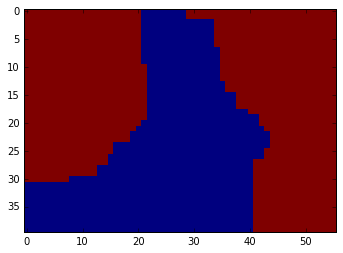

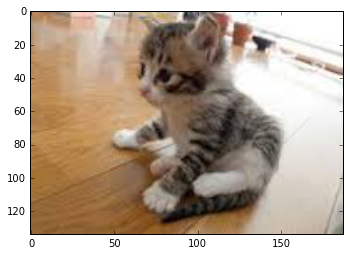

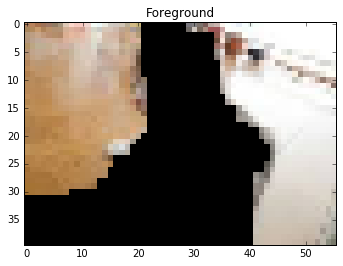

In [58]:
im = plt.imread('data/gibbs/try2.jpg')
plt.imshow(im)
[data, im] = preproc_data(im, scale = 0.3,debug=True) # data is normalized image
##let's give more weight on eta, keep gamma lower

random_seed = 100 # Change this in your experiment
random.seed(random_seed)

(h, w) = data.shape
mat = random.random((h,w))
mat[mat>0.5] = 1
mat[mat<=0.5] = -1
random_state = mat

# Initial the random state
init_state = random_state

# Set parameters
gamma = 20
eta = 1

new_state = random_state.copy()
E = [energy(init_state, data, gamma, eta)] # array of energies at each iteration

f, ax = plt.subplots() # prepare animation
for i in range(60):
    clear_output(wait=True)
    new_state = gibbs_sampler(new_state, data, gamma, eta)
    E.append(energy(new_state, data, gamma, eta))

    # time.sleep(1)
    myimshow(new_state)
    display(f)

plt.title("Foreground")
mask = (new_state==1)
fg = im.copy()
for i in range(3): 
    fg[:,:,i] = fg[:,:,i] * mask
plt.imshow(fg, cmap='gray', interpolation='nearest')

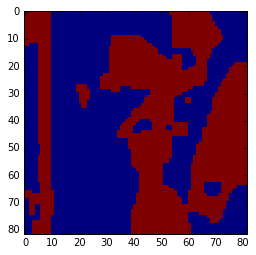

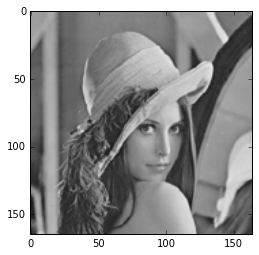

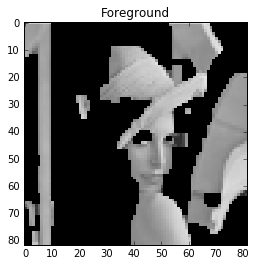

In [34]:
im = plt.imread('data/gibbs/try3.png')
plt.imshow(im)
[data, im] = preproc_data(im, scale = 0.5, debug=True) # data is normalized image
##let's give more weight on eta, keep gamma lower

random_seed = 300 # Change this in your experiment
random.seed(random_seed)

(h, w) = data.shape
mat = random.random((h,w))
mat[mat>0.5] = 1
mat[mat<=0.5] = -1
random_state = mat

# Initial the random state
init_state = random_state

# Set parameters
gamma = 20
eta = 10

new_state = random_state.copy()
E = [energy(init_state, data, gamma, eta)] # array of energies at each iteration

f, ax = plt.subplots() # prepare animation
for i in range(60):
    clear_output(wait=True)
    new_state = gibbs_sampler(new_state, data, gamma, eta)
    E.append(energy(new_state, data, gamma, eta))

    # time.sleep(1)
    myimshow(new_state)
    display(f)

plt.title("Foreground")
mask = (new_state==1)
fg = im.copy()
for i in range(3): 
    fg[:,:,i] = fg[:,:,i] * mask
plt.imshow(fg, cmap='gray', interpolation='nearest')

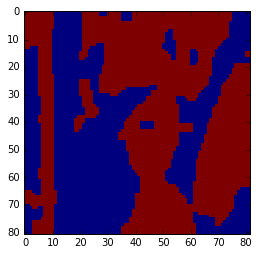

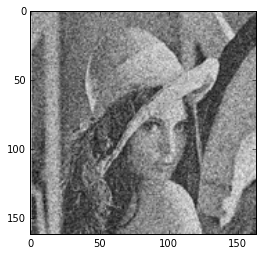

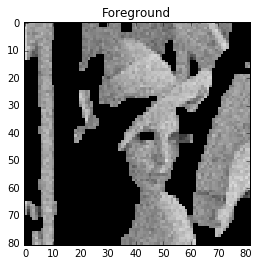

In [36]:
im = plt.imread('data/gibbs/try4.png')
plt.imshow(im)
[data, im] = preproc_data(im,scale=0.5, debug=True) # data is normalized image
##let's give more weight on eta, keep gamma lower

random_seed = 300 # Change this in your experiment
random.seed(random_seed)

(h, w) = data.shape
mat = random.random((h,w))
mat[mat>0.5] = 1
mat[mat<=0.5] = -1
random_state = mat

# Initial the random state
init_state = random_state

# Set parameters
gamma = 20
eta = 10

new_state = random_state.copy()
E = [energy(init_state, data, gamma, eta)] # array of energies at each iteration

f, ax = plt.subplots() # prepare animation
for i in range(60):
    clear_output(wait=True)
    new_state = gibbs_sampler(new_state, data, gamma, eta)
    E.append(energy(new_state, data, gamma, eta))

    # time.sleep(1)
    myimshow(new_state)
    display(f)

plt.title("Foreground")
mask = (new_state==1)
fg = im.copy()
for i in range(3): 
    fg[:,:,i] = fg[:,:,i] * mask
plt.imshow(fg, cmap='gray', interpolation='nearest')

### Answer 3
Around what iteration does the sampler converge for the Einstein image with γ=20 and η=1 and how do you know it? Don't just say "the image stopped changing very much"! Hint: look carefully at the demo above to see if there's anything that will help you diagnose convergence.

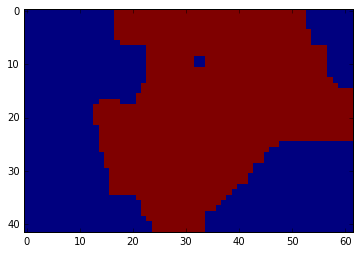

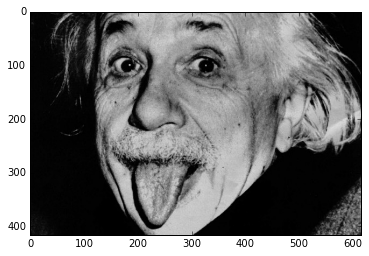

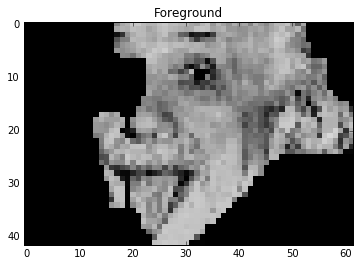

In [56]:
im = plt.imread('data/gibbs/gibbs_demo.jpg')
plt.imshow(im)
[data, im] = preproc_data(im, debug=True) # data is normalized image


random_seed = 1 # Change this in your experiment
random.seed(random_seed)

(h, w) = data.shape
mat = random.random((h,w))
mat[mat>0.5] = 1
mat[mat<=0.5] = -1
random_state = mat

# Initial the random state
init_state = random_state

# Set parameters
gamma = 20
eta = 1

new_state = random_state.copy()
E = [energy(init_state, data, gamma, eta)] # array of energies at each iteration

f, ax = plt.subplots() # prepare animation
for i in range(60):
    clear_output(wait=True)
    new_state = gibbs_sampler(new_state, data, gamma, eta)
    E.append(energy(new_state, data, gamma, eta))

    # time.sleep(1)
    myimshow(new_state)
    display(f)

plt.title("Foreground")
mask = (new_state==1)
fg = im.copy()
for i in range(3): 
    fg[:,:,i] = fg[:,:,i] * mask
plt.imshow(fg, cmap='gray', interpolation='nearest')



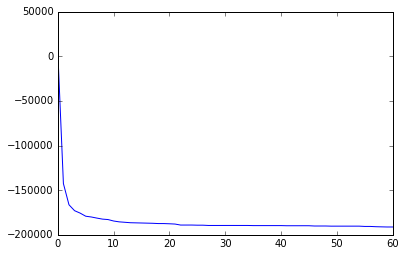

In [47]:
plt.plot(E)

In [49]:
print np.diff(E)

[ -1.47395813e+05  -2.37606565e+04  -6.59843303e+03  -2.72308092e+03
  -3.47820619e+03  -8.54752206e+02  -1.24399382e+03  -1.13953893e+03
  -4.97945221e+02  -1.62527444e+03  -9.49908668e+02  -4.73524782e+02
  -4.94744038e+02  -1.54245793e+02  -1.59915300e+02  -1.59604225e+02
  -1.62707226e+02  -3.06724845e+02  -6.03877181e+00  -2.34410365e+02
  -3.10114913e+02  -1.11416750e+03  -2.82716927e+00   9.19508417e+00
  -1.61174222e+02  -2.87352319e+00  -3.11307794e+02   1.82013789e+00
   3.30779805e+00   7.56492796e+00   5.07485580e+00  -9.79064932e+00
   1.62873267e+00   3.77201700e-01  -1.53028787e+02  -4.31407140e+00
   4.39998897e+00  -2.27805057e-01  -5.31657593e+00   5.10126241e+00
  -1.54886011e+02   6.30335038e-01  -3.83409745e+00   1.17329836e+01
  -1.16985518e+01  -3.01359716e+02  -9.65371574e-01   2.01941882e+00
  -1.63862554e+02   6.80654934e+00  -2.32174248e+00   3.71797598e+00
   1.29414099e+00  -2.74964345e+00  -3.16063906e+02  -3.40438859e-01
  -3.13422903e+02  -1.58990292e+02

-121427.889443


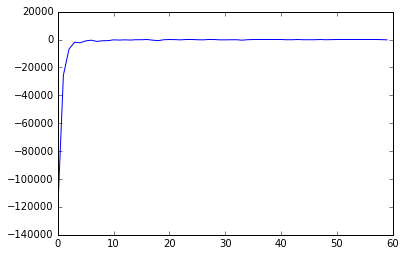

In [65]:
dE = np.diff(E)
plt.plot(dE)
print dE[0]